### Step 0: Importing necessary libraries

In [21]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

### Step 1: Reading the dataset

In [22]:
df = pd.read_csv("Restaurant_revenue.csv")
print(df["Cuisine_Type"].unique())
display(df.head(10))
df.info()

['Japanese' 'Italian' 'American' 'Mexican']


,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121
5,92,19.427670,13.114473,American,43.099950,1,10,399.867507
6,96,35.350343,16.960318,American,20.181622,0,86,496.653687
7,84,46.314645,14.486349,Italian,28.921100,1,1,417.158607
8,84,22.647863,15.841873,American,11.732611,0,26,352.148065
9,97,33.532267,8.095969,Italian,37.973579,0,98,272.793517


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


### Step 2: Cleaning up the dataset

In [ ]:
from sklearn.preprocessing import OneHotEncoder

original_records = df.shape[0]
df = df.dropna(how="any")
print(original_records - df.shape[0], "records have been dropped.")

variables = ['Cuisine_Type']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

df.head()

0 records have been dropped.


,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Cuisine_Type_American,Cuisine_Type_Italian,Cuisine_Type_Japanese,Cuisine_Type_Mexican
0,61,43.117635,12.663793,36.236133,0,45,350.912040,False,False,True,False
1,24,40.020077,4.577892,17.952562,0,36,221.319091,False,True,False,False
2,81,41.981485,4.652911,22.600420,1,91,326.529763,False,False,True,False
3,70,43.005307,4.416053,18.984098,1,59,348.190573,False,True,False,False
4,30,17.456199,3.475052,12.766143,1,30,185.009121,False,True,False,False


### Step 3: Train/test/validation split

c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


<Axes: >

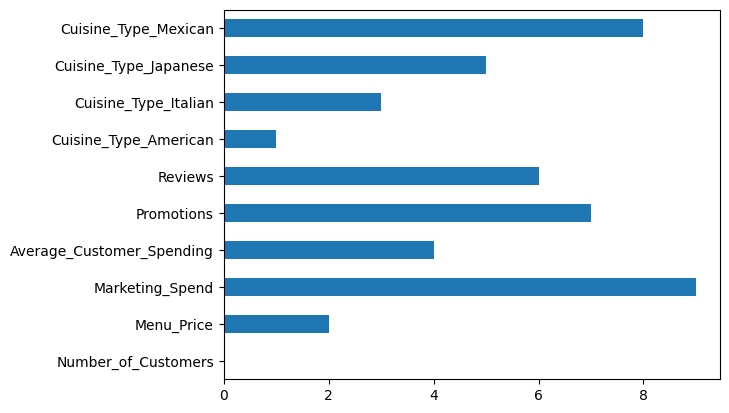

In [24]:
X = df.drop(columns="Monthly_Revenue")
y = df["Monthly_Revenue"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#df.corr(numeric_only=True)

from skfeature.function.similarity_based import fisher_score

# Convert boolean columns to integers for Fisher Score
X_numeric = X.copy()
for col in X_numeric.select_dtypes(include='bool').columns:
	X_numeric[col] = X_numeric[col].astype(int)

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X_numeric.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

### Step 4: Creating neural network

In [25]:
variable_amount = len(X.columns)

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(18, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.01)),
        layers.Dropout(0.1),
        layers.Dense(8, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511 (2.00 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 20 (80.00 B)

### Step 5: Fitting data to neural netwrok

Epoch 1/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 82037.2812 - val_loss: 86720.1562
Epoch 2/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 81884.1562 - val_loss: 86133.4844
Epoch 3/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 81797.2891 - val_loss: 85888.1406
Epoch 4/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 81704.7109 - val_loss: 85711.9141
Epoch 5/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 81580.7969 - val_loss: 85510.6172
Epoch 6/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 81351.7266 - val_loss: 85135.2109
Epoch 7/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 80900.8359 - val_loss: 84351.1172
Epoch 8/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 79978.7969 - val_loss: 82746.1250
Epoch 9/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 78153.3047 - val_loss: 79706.6016
Epoch 10/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 74473.7891 - val_loss: 74028.2812
Epoch 11/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

<Axes: >

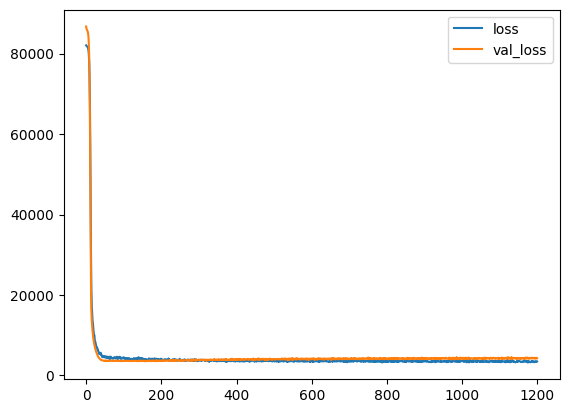

In [26]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val))
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

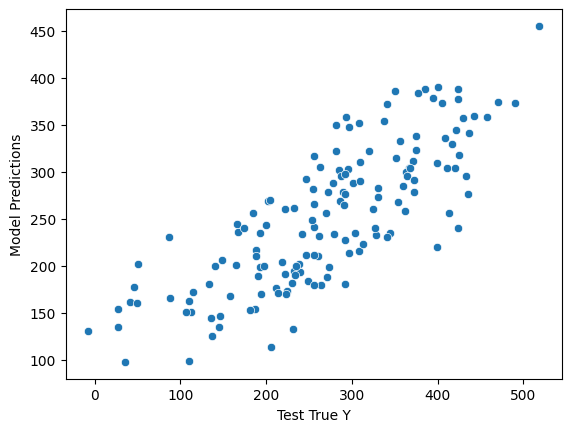

In [27]:

# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

C:\Users\zsolt\AppData\Local\Temp\ipykernel_28160\1091839839.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


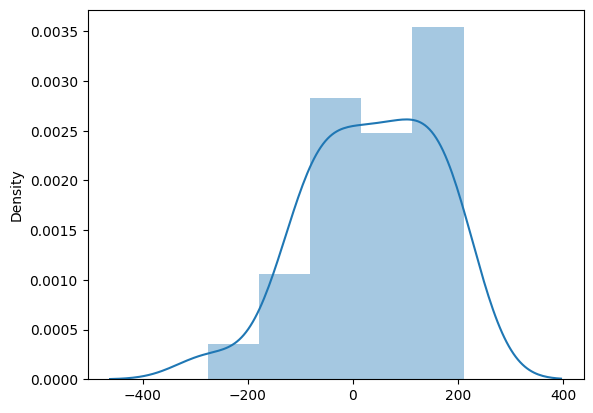

In [28]:


sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [29]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
57.06 $

MSE
4867.35 $^2

RMSE:
69.77 $

R-squared:
0.59

Explained variance score:
0.62


In [30]:
#pip install tk
import tkinter as tk

root = tk.Tk()
root.geometry("500x500")
root.title("ANN for regression")

label = tk.Label(root, text="Teszt")
label.pack()

button = tk.Button(root, text="gomb", function=print("asd"))
button.pack()

tk.mainloop()



asd
